# Phylo2Matrix - Demo

## Python

### 3rd party imports

In [1]:
!pip install PyQt5

  Using cached PyQt5-5.15.11-cp38-abi3-manylinux_2_17_x86_64.whl.metadata (2.1 kB)
  Using cached PyQt5_sip-12.15.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (421 bytes)
  Using cached PyQt5_Qt5-5.15.15-py3-none-manylinux2014_x86_64.whl.metadata (536 bytes)
Using cached PyQt5-5.15.11-cp38-abi3-manylinux_2_17_x86_64.whl (8.2 MB)
Using cached PyQt5_Qt5-5.15.15-py3-none-manylinux2014_x86_64.whl (59.8 MB)
Using cached PyQt5_sip-12.15.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.whl (270 kB)


In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

from ete3 import Tree
from matplotlib.collections import LineCollection

### Definition

* Newick strings can also have branch lengths, so it is also desirable to store not only the topology (which the core Phylo2Vec does), but also the branch lengths

In this setup:
* 1st column is v[i]
* 2nd column is where leaf i branched out from branch v[i]
* 3rd column is the branch length leading to leaf i

### Sampling a random tree

In [2]:
from phylo2vec.utils import sample_matrix, seed_everything

seed_everything(42)

sample_matrix?

Signature:
sample_matrix(
    n_leaves,
    ordered=False,
    branch_length_distribution='uniform',
    **kwargs,
)
Docstring:
Sample a random tree with branch lengths via Phylo2Vec

By default, branch lengths are sampled uniformly in (0, 1)

1st column: v (topology)
2nd column: where to branch from v[i]
3rd column: length of the branch yielding leaf i

Parameters
----------
n_leaves : int
    Number of leaves
ordered : bool, optional
    If True, sample an ordered tree topology, by default False

    True:
    v_i in {0, 1, ..., i} for i in (0, n_leaves-1)

    False:
    v_i in {0, 1, ..., 2*i} for i in (0, n_leaves-1)
branch_length_distribution : str, optional
    Distribution upon which branch lengths are distributed, by default 'uniform'
kwargs :
    All optional arguments are passed to the branch length distribution

Returns
-------
numpy.ndarray
    Phylo2Mat matrix
File:      ~/src/phylo2vec_dev/phylo2vec/utils/random.py
Type:      function

In [7]:
m = sample_matrix(n_leaves=10)

print(repr(m))

array([[ 0.        ,  0.37451172,  0.9506836 ],
       [ 2.        ,  0.7319336 ,  0.5986328 ],
       [ 0.        ,  0.15600586,  0.15600586],
       [ 4.        ,  0.05807495,  0.86621094],
       [ 7.        ,  0.6010742 ,  0.7080078 ],
       [10.        ,  0.02058411,  0.96972656],
       [ 6.        ,  0.83251953,  0.21228027],
       [ 7.        ,  0.18188477,  0.18334961],
       [11.        ,  0.30419922,  0.52490234]], dtype=float32)


In [8]:
m_ordered = sample_matrix(n_leaves=10, ordered=True)

print(repr(m_ordered))

array([[0.        , 0.43188477, 0.29125977],
       [1.        , 0.6118164 , 0.13952637],
       [1.        , 0.29223633, 0.36645508],
       [3.        , 0.4560547 , 0.78515625],
       [0.        , 0.19970703, 0.51416016],
       [0.        , 0.59228516, 0.04644775],
       [1.        , 0.6074219 , 0.17053223],
       [6.        , 0.06506348, 0.94873047],
       [7.        , 0.9658203 , 0.80859375]], dtype=float32)


We can also check that a matrix is valid

This checks that the topology is correct and that the branch lengths are positive

In [3]:
from phylo2vec.utils import check_m

check_m?

Signature: check_m(m)
Docstring:
Input validation of a Phylo2Mat matrix

The input is checked for the Phylo2Vec constraints and positive branch lengths

Parameters
----------
m : numpy.ndarray
    Phylo2Mat matrix
File:      ~/src/phylo2vec_dev/phylo2vec/utils/validation.py
Type:      function

In [10]:
check_m(m)  # returns None

v_awkward = m.copy()

v_awkward[5] = 11

check_m(v_awkward)  # AssertionError

[ 0.  2.  0.  4.  7. 11.  6.  7. 11.] [ True  True  True  True  True  True  True  True  True] [ True  True  True  True  True False  True  True  True]


AssertionError: None

### Converting a matrix to a Newick string

* ```to_newick``` is a wrapper of two functions: ```_get_ancestry``` and ```_build_newick```

In [4]:
from phylo2vec.matrix import to_newick

to_newick?

Signature: to_newick(m)
Docstring:
Recover a rooted tree (in Newick format) from a Phylo2Mat m

The functions wraps the base function ```_get_ancestry```
and a new _build_newick_with_bls which takes into account branch lengths

Parameters
----------
m : numpy.array
    Phylo2Mat matrix

* 1st column is v[i]
* 2nd column is where leaf i branched out from branch v[i]
* 3rd column is the branch length leading to leaf i

Returns
-------
newick : str
    Newick tree
File:      ~/src/phylo2vec_dev/phylo2vec/matrix/to_newick.py
Type:      function

In [8]:
newick = to_newick(m)

print(newick)

(((((((0:0.156006,3:0.156006)12:0.058075,9:0.866211)13:0.601074,4:0.708008)14:0.020584,1:0.969727)15:0.83252,5:0.21228)16:0.181885,2:0.18335)17:0.304199,(6:0.731934,(7:0.374512,8:0.950684)10:0.598633)11:0.524902)18;


In [13]:
def plot_tree_ete3(
    newick,
    align_names=False,
    name_offset=None,
    font_size=9,
    label_with_node_style=True,
    ax=None,
):
    """
    Plots a ete3.Tree object using matploltib.

    Adapted from: https://gist.github.com/jolespin/5d90deff552138d73de7ed4bdd9ac57a

    Parameters
    ----------
    newick : str
    align_names: bool
        If True names will be aligned vertically, by default False
    name_offset : float, optional
        Offset relative to tips to write leaf_names. In BL scale, by default None
    font_size : int, optional
        Text font size, by default 9
    label_with_node_style : bool, optional
        If True, color the node label with the node's style color, by default True
    ax : matplotlib.Axes object, optional
        Object on which the tree will be plotted, by default None

    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib axis containing the drawn tree
    """
    # https://chart-studio.plotly.com/~empet/14819.embed
    tree = Tree(newick, format=1)

    shape_dict = {"circle": "o", "square": "s", "sphere": "o"}
    linestyle_dict = dict(enumerate(("-", "--", ":")))

    if ax is None:
        ax = plt.gca()

    aligned_lines = []

    max_x = max(n.get_distance(tree) for n in tree.iter_leaves())

    if name_offset is None:
        name_offset = max_x / 50.0

    node_pos = {n2: i for i, n2 in enumerate(tree.get_leaves()[::-1])}
    node_list = itertools.chain(tree.iter_descendants(strategy="postorder"), [tree])

    # draw tree
    for node in node_list:
        # Parent style
        pstyle = node.img_style

        x = sum(n2.dist for n2 in node.iter_ancestors()) + node.dist

        if node.is_leaf():
            y = node_pos[node]
            if align_names:
                x = max_x
                aligned_lines.append(((x, y), (max_x + name_offset, y)))

        else:
            y = np.mean([node_pos[n2] for n2 in node.children])
            node_pos[node] = y

            # draw vertical line
            ax.plot(
                [x, x],
                [node_pos[node.children[0]], node_pos[node.children[-1]]],
                c=pstyle["vt_line_color"],
                linestyle=linestyle_dict[pstyle["vt_line_type"]],
                linewidth=0.5 * (pstyle["vt_line_width"] + 1),
            )

            # draw horizontal lines
            for child in node.children:
                # Child style
                cstyle = child.img_style
                ax.plot(
                    [x, x + child.dist],
                    [node_pos[child], node_pos[child]],
                    c=cstyle["hz_line_color"],
                    linestyle=linestyle_dict[cstyle["hz_line_type"]],
                    linewidth=0.5 * (cstyle["hz_line_width"] + 1),
                )

        # Node label
        ax.text(
            x + name_offset,
            y,
            node.name,
            va="center",
            size=font_size,
            c=pstyle["fgcolor"] if label_with_node_style else "k",
        )

        # Node point
        ax.scatter(
            x,
            y,
            s=pstyle["size"] ** 2 / 2,
            marker=shape_dict[pstyle["shape"]],
            c=pstyle["fgcolor"],
            zorder=10,
        )

    ali_line_col = LineCollection(aligned_lines, colors="k")

    ax.add_collection(ali_line_col)

    ax.set_axis_off()
    return ax

Example to understand the matrix form is the fourth row of ```m```:

``` [ 4.        ,  0.05807495,  0.86621094]```

We see here that the branch yielding leaf 4 "sprouted" early on (0.05 away from its parents) and pretty far (branch length of 0.866).

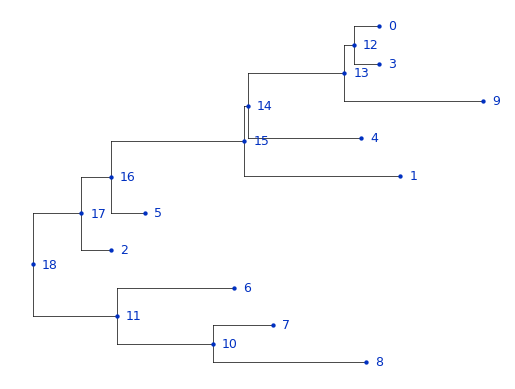

In [14]:
plot_tree_ete3(newick)
plt.show()

### Converting a Newick with branch lengths to a matrix

In [5]:
from phylo2vec.matrix import to_matrix

to_matrix?

Signature: to_matrix(newick)
Docstring:
Convert a Newick string with parent labels and branch lengths to a matrix

This functions wraps a new _reduce function with branch lengths
and the base functions ```_find_cherries``` and ```_build_vector```

Parameters
----------
newick : str
    Newick string for a tree

Returns
-------
m : numpy.ndarray
    Phylo2Mat matrix
File:      ~/src/phylo2vec_dev/phylo2vec/matrix/to_matrix.py
Type:      function

In [6]:
# Let's generate a new v with 7 leaves using sample
m7 = sample_matrix(7)

print(f"m (sampled):\n{repr(m7)}")

newick7 = to_newick(m7)

print(f"newick: {newick7}")

m7_new = to_matrix(newick7)

print(f"m (convert):\n{repr(m7_new)}")

m (sampled):
array([[0.        , 0.37451172, 0.9506836 ],
       [1.        , 0.7319336 , 0.5986328 ],
       [1.        , 0.15600586, 0.15600586],
       [3.        , 0.05807495, 0.86621094],
       [8.        , 0.6010742 , 0.7080078 ],
       [5.        , 0.02058411, 0.96972656]], dtype=float32)
newick: ((0:0.601074,((1:0.156006,(3:0.731934,4:0.598633)8:0.156006)9:0.058075,2:0.866211)10:0.708008)11:0.020584,(5:0.374512,6:0.950684)7:0.969727)12;
m (convert):
array([[0.        , 0.37451172, 0.9506836 ],
       [1.        , 0.7319336 , 0.5986328 ],
       [1.        , 0.15600586, 0.15600586],
       [3.        , 0.05807495, 0.86621094],
       [8.        , 0.6010742 , 0.7080078 ],
       [5.        , 0.02058411, 0.96972656]], dtype=float32)


phylo2mat can also convert Newick strings without parent labels. 
We also have several functions in ```phylo2vec.utils.newick``` to process Newick strings

In [7]:
from phylo2vec.utils import remove_parent_labels

newick7_no_parent = remove_parent_labels(newick7)

print(f"Newick with parent labels: {newick7}")
print(f"Newick with parent labels: {newick7_no_parent}")

Newick with parent labels: ((0:0.601074,((1:0.156006,(3:0.731934,4:0.598633)8:0.156006)9:0.058075,2:0.866211)10:0.708008)11:0.020584,(5:0.374512,6:0.950684)7:0.969727)12;
Newick with parent labels: ((0:0.601074,((1:0.156006,(3:0.731934,4:0.598633):0.156006):0.058075,2:0.866211):0.708008):0.020584,(5:0.374512,6:0.950684):0.969727);


In [8]:
from phylo2vec.matrix import to_matrix_no_parents

to_matrix_no_parents(newick7_no_parent)  # Same as m7, m7_new

array([[0.        , 0.37451172, 0.9506836 ],
       [1.        , 0.7319336 , 0.5986328 ],
       [1.        , 0.15600586, 0.15600586],
       [3.        , 0.05807495, 0.86621094],
       [8.        , 0.6010742 , 0.7080078 ],
       [5.        , 0.02058411, 0.96972656]], dtype=float32)

Many functionalities are currently missing for phylo2mat to be complete. These funcs are more complicated to implement b/c of the branch lengths (e.g., adding/removing leaves, reodering...)

In [22]:
m = sample_matrix(20)

n = to_newick(m)

m2 = to_matrix(n)

np.array_equal(m, m2)

True